# Описание проекта.

В нашем распоряжение данные популярного сервиса аренды самокатов GoFast. Данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируем данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти:
1.  Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. 
2. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 
3. Проверем гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

In [28]:
# импортируем все необходимые библиотеки 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

#### Шаг 1. Загрузка данных

In [29]:
#прочитаем и сохраним в переменную информацию о клиентах
users_data = pd.read_csv('/datasets/users_go.csv')
users_data.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [30]:
# посмотрим на общую информацию о таблице
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [31]:
#прочитаем и сохраним в переменную информацию о поездках
rides_data = pd.read_csv('/datasets/rides_go.csv')
rides_data.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [32]:
# посмотрим на общую информацию о таблице
rides_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [33]:
#прочитаем и сохраним в переменную информацию о подписках
subscriptions_data = pd.read_csv('/datasets/subscriptions_go.csv')
subscriptions_data

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [34]:
# посмотрим на общую информацию о таблице
subscriptions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


При первом знакомстве с данными видно , что в таблицах есть общие элементы по которым можно будет их объеденить. Нужно будет поменять тип данных для записи даты. На следующем этапе проверить наличие дубликатов и пропусков.

#### Шаг 2. Предобработка данных

In [35]:
rides_data['date'].head() # проверим формат записи времени

0    2021-01-01
1    2021-01-18
2    2021-04-20
3    2021-08-11
4    2021-08-28
Name: date, dtype: object

In [36]:
# проверим за какой период представленны данные
rides_data['date'].value_counts()

2021-12-22    72
2021-01-12    70
2021-12-27    69
2021-06-09    67
2021-08-20    67
              ..
2021-07-30    35
2021-11-07    35
2021-12-15    34
2021-02-02    34
2021-07-03    31
Name: date, Length: 364, dtype: int64

In [37]:
rides_data['date'] = pd.to_datetime(rides_data['date'], format='%Y.%m.%d') 
rides_data['date'].head() # приведем формат времени к "datetime64"

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
Name: date, dtype: datetime64[ns]

In [38]:
rides_data['month'] = rides_data['date'].dt.month
rides_data['month'].head() # добавим новый столбец с номером месяца

0    1
1    1
2    4
3    8
4    8
Name: month, dtype: int64

In [39]:
# проверим не склеились ли данные после агрегации. все в порядке
rides_data['date'].value_counts()

2021-12-22    72
2021-01-12    70
2021-12-27    69
2021-08-20    67
2021-06-09    67
              ..
2021-11-07    35
2021-07-30    35
2021-12-15    34
2021-02-02    34
2021-07-03    31
Name: date, Length: 364, dtype: int64

In [40]:
# проверим пропуски в таблице с клиентами. их нет
users_data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [41]:
# проверим кол-во явных дубликатов в таблице 
users_data.duplicated().sum()

31

In [42]:
# 31 явный дубликат, удалим их
users_data = users_data.drop_duplicates()

In [43]:
# проверим есть ли неявные дуликаты в названиях нас. пунктов. их нет 
users_data['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

In [44]:
# проверим пропуски в таблице с поездками. их нет
rides_data.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [45]:
# проверим кол-во явных дубликатов в таблице . их нет
rides_data.duplicated().sum()

0

В таблице "subscriptions_data" всего две строчки. Очивидно , что в ней нет пропусков и дубликатов.

# вывод по предобработке

В данных не пропусков , но были дубликаты. Возможные причины появления дубликатов :
1. Технические ошибки с многократной загрузкой одного фрагмента данных.
2. Повторный ввод одной и той же информации в сочетании с отсутствием проверок на существование такой же записи в базе данных.

#### Шаг 3. Исследовательский анализ данных

##### изучим частоту встречаемости городов

In [46]:
# частота городов
users_data['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

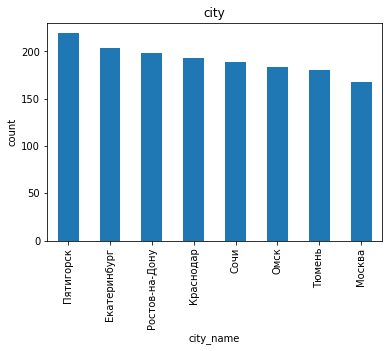

In [48]:
# график частоты встречаемости городов 
users_data['city'].value_counts().plot.bar(xlabel='city_name', ylabel='count')
plt.title('city')
plt.show()

В итоге мы видим, что главными городами, по использованию самакатов являются : Пятигорск, Екатеринбург.

#####  изучим соотношение пользователей с подпиской и без подписки

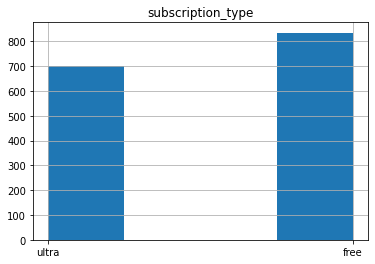

In [49]:
# график пользовотелей с подпиской и без
users_data['subscription_type'].hist(bins=4)
plt.title('subscription_type')
plt.show()

In [50]:
# кол-во клиентов по типу подписки
users_data.groupby('subscription_type').count()

,user_id,name,age,city
subscription_type,,,,
free,835,835,835,835
ultra,699,699,699,699


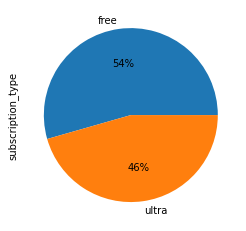

In [51]:
users_data['subscription_type'].value_counts().plot(kind='pie',autopct='%1.0f%%')
plt.show()

На графике видно , что 54% пользователей не пользуются подпиской, у 46% пользователей есть подписка.

##### Изучим возраст пользователей

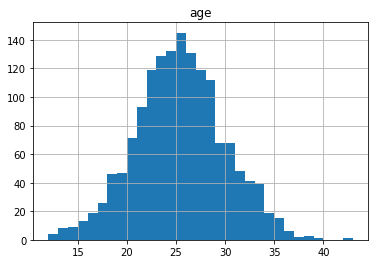

In [52]:
# график расспрделения возрастов клиентов
users_data['age'].hist(bins=users_data['age'].max() - users_data['age'].min())
plt.title('age')
plt.show()

In [53]:
# дополнительно посмотрим на основные показатели 
users_data['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Видим , что основная масса пользователей это люди в возрасте от 22 до 28 лет.

##### Изучим расстояние, которое пользователь преодолел за одну поездку

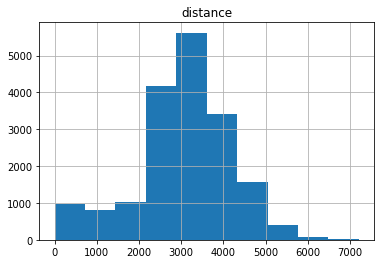

In [54]:
# график распределения растояния поездок
rides_data['distance'].hist()
plt.title('distance')
plt.show()

In [55]:
# распределение расстояния поездок
rides_data['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Основное кол-во поездок происходит на росстояние примерно от 2500 до 3100 метров.

##### Изучим продолжительность поездок

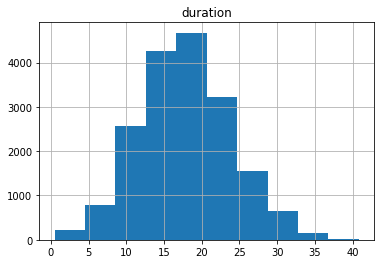

In [56]:
# график распределения продолжительности поездки
rides_data['duration'].hist()
plt.title('duration')
plt.show()

In [57]:
# расспределение продолжительности поездок
rides_data['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

В основном поездки длятся от 13 до 21 минуты.

# Вывод по исследовательскому анализу.

В результате анализа было выявленно , что :
1. Главными городами, по использованию самакатов являются : Пятигорск, Екатеринбург.
2. Большая часть клиентов пользуются самокатами без подписки.
3. Основная масса пользователей это люди в возрасте от 22 до 28 лет.
4. Основное кол-во поездок происходит на росстояние примерно от 2500 до 3100 метров.
5. В основном поездки длятся от 13 до 21 минуты.


#### Шаг 4. Объединение данных

# Объеденим все таблицы в одну.

In [58]:
users_and_rides = users_data.merge(rides_data,on='user_id', how='left')
users_and_rides

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11


In [59]:
# Общая таблица
final_table = users_and_rides.merge(subscriptions_data, on='subscription_type', how='left')
final_table

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


Проверим наличие пропусков в объединенной таблице. Пропусков нет.

In [60]:
final_table.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Так же , проверим совпадает ли объединенная таблица по размеру с исходными. Кол-во строк задает таблица с поездками - 18068 строк, в трех таблицах 14 столбцов , в итоговой таблице 12 столбцов т.к. 2 столбца смежные. Объединение таблиц прошло корректно.

In [61]:
# размер таблицы с информацией о подписках
subscriptions_data.shape

(2, 4)

In [62]:
# размер таблицы с пользователями
users_data.shape

(1534, 5)

In [63]:
# размер таблицы с поездками
rides_data.shape

(18068, 5)

In [64]:
# размер финальной таблицы
final_table.shape

(18068, 12)

Сделаем таблицу пользователей с подпиской.

In [65]:
# таблица пользователей с подпиской
final_table_ultra = final_table.query('subscription_type == "ultra"')
final_table_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Сделаем таблицу пользователей без подписки.

In [66]:
# таблица пользователей без подписки
final_table_free = final_table.query('subscription_type == "free"')
final_table_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


# Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

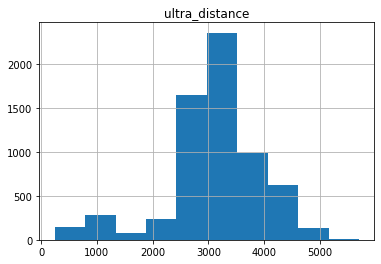

In [67]:
# график пройденного расстояния для пользователей с подпиской
final_table_ultra['distance'].hist()
plt.title('ultra_distance')
plt.show()

In [68]:
# статистика пройденного расстояния для пользователей с подпиской
final_table_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

В основном пользователи с подпиской проезжают от 2700 до 3500 метров.

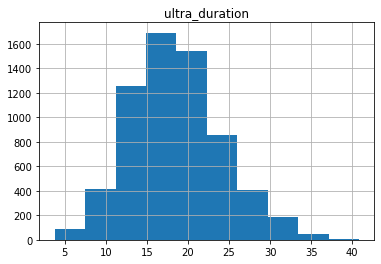

In [69]:
# график времени поездок для пользователей с подпиской
final_table_ultra['duration'].hist()
plt.title('ultra_duration')
plt.show()

In [70]:
# статистика времени поездок для пользователей с подпиской
final_table_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

От 14 до 21 минуты длятся основные поездки пользователей с подпиской.

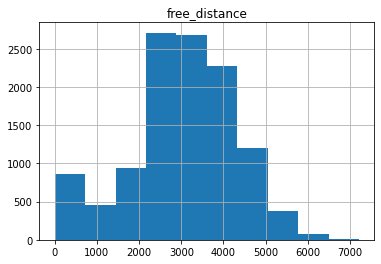

In [71]:
# график пройденного расстояния для пользователей без подписки
final_table_free['distance'].hist()
plt.title('free_distance')
plt.show()

In [72]:
# статистика пройденного расстояния для пользователей без подписки
final_table_free['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

В основном пользователи без подписки проезжают от 2300 до 3900 метров.

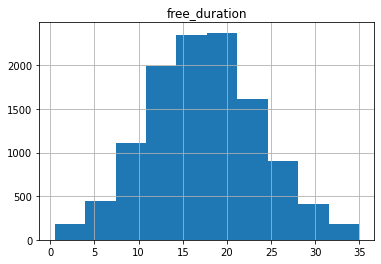

In [73]:
# график времени поездок для пользователей без подписки
final_table_free['duration'].hist()
plt.title('free_duration')
plt.show()

In [74]:
# статистика времени поездок для пользователей без подписки
final_table_free['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

От 12 до 21 минуты преимущественно длятся поездки для пользователей без подписки.

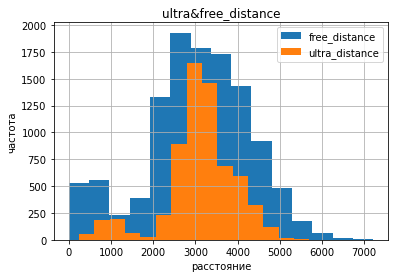

In [75]:
# совместный график расстояния поездок для пользователей обеих групп
final_table_free['distance'].hist(bins=15, label='free_distance')
final_table_ultra['distance'].hist(bins=15, label='ultra_distance')
plt.title('ultra&free_distance')
plt.xlabel('расстояние')
plt.ylabel('частота')
plt.legend()
plt.show()

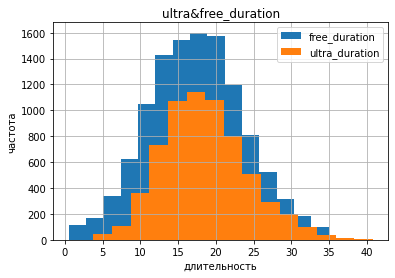

In [76]:
# совместный график длительности поездок для пользователей обеих групп
final_table_free['duration'].hist(bins=15, label='free_duration')
final_table_ultra['duration'].hist(bins=15, label='ultra_duration')
plt.title('ultra&free_duration')
plt.xlabel('длительность')
plt.ylabel('частота')
plt.legend()
plt.show()

На совместных графиках расстояния и длительности поездок заметно, что для пользователей с подпиской характерен меньший разброс в данных т.е. их поездки более равномерные , чем у пользователей без подписок. Так же пользователи с подпиской совершают меньше коротких поездок. Вполне возможно , что пользователи с подпиской регулярно пользуются самокатом как повседневным средством передвижения.

## Шаг 5. Подсчёт выручки

### Создадим датафрейм с агрегированными данными о поездках на основе общей таблицы: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Добавим столбец с помесячной выручкой, которую принёс каждый пользователь

In [78]:
# продолжительность каждой поездки округлим до следующего целого числа
final_table['duration'] = np.ceil(final_table['duration'])

# датафрейм с агрегированными данными о поездках на основе общей таблицы
final_table_pivot = final_table.pivot_table(index=['user_id','month'], 
    values=['distance','duration','subscription_type','minute_price','start_ride_price', 'subscription_fee'],
    aggfunc={'distance':'sum','duration':['sum','count'],'subscription_type':'first','minute_price':'first',
    'start_ride_price':'first','subscription_fee':'first'})
# переименуем столбцы
final_table_pivot.columns = ['distance','rides','duration','minute_price','start_ride_price','subscription_fee','subscription_type']    


In [79]:
# проверим наличие пропусков в сводной таблице. их нет
final_table_pivot.isna().sum()

distance             0
rides                0
duration             0
minute_price         0
start_ride_price     0
subscription_fee     0
subscription_type    0
dtype: int64

In [80]:
# создадим функцию для подсчета выручки
def rev(row):
    revenue = row['start_ride_price']*row['rides'] + \
    row['minute_price']*row['duration']+row['subscription_fee']
    return revenue
# добавим новый столбец с помесячной выручкой, которую принёс каждый пользователь
final_table_pivot['revenue'] = final_table_pivot.apply(rev,axis=1)

In [81]:
final_table_pivot.head()

distance  rides  duration  minute_price  start_ride_price  \
user_id month                                                                 
1       1      7027.511294      2      42.0             6                 0   
        4       754.159807      1       7.0             6                 0   
        8      6723.470560      2      46.0             6                 0   
        10     5809.911100      2      32.0             6                 0   
        11     7003.499363      3      56.0             6                 0   

               subscription_fee subscription_type  revenue  
user_id month                                               
1       1                   199             ultra    451.0  
        4                   199             ultra    241.0  
        8                   199             ultra    475.0  
        10                  199             ultra    391.0  
        11                  199             ultra    535.0

#### Шаг 6. Проверка гипотез

Первая гипотеза: тратят ли пользователи с подпиской больше времени на поездки?

Нулевая гипотеза - пользователи обеих категорий трятят одинаковое время на поездки <br>
Альтернативная гипотеза - пользователи с подпиской трят больше времени на поездки

In [82]:
# проведем t-тест
ultra_dur = final_table_ultra['duration']
free_dur = final_table_free['duration']

alpha = 0.05
results = st.ttest_ind(ultra_dur,free_dur, alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу') 

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


В результате проведения теста нулевая гипотеза была отвергнута. Подтвердилась льтернативная гипотеза - пользователи с подпиской трят больше времени на поездки.

Вторая гипотеза: можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

Нулевая гипотеза - среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров. <br>
Алетренативная гипотеза - среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 метровов.

In [59]:
# проводим тест
ultra_dis = final_table_ultra['distance']

prev_distance_value = 3130
alpha = 0.05
results = st.ttest_1samp(
    ultra_dis,
    prev_distance_value,
    alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу') 

p-значение: 0.9195368847849785
Нет оснований отвергнуть нулевую гипотезу


Тест показал, что нет оснований отвергать нулевую гипотезу. Можно сделать вывод , что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

Это говорит о том, что износ самокатов будет лежать в приделах оптимальных значений.

Третья гипотиза : будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Нулевая гипотеза - месячная выручка для пользователй обеих групп одинаковая. <br>
Алетернативная гипотеза - месячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

In [60]:
# проводим тест
ultra_rev = final_table_pivot.loc[final_table_pivot['subscription_type'] == 'ultra','revenue']
free_rev = final_table_pivot.loc[final_table_pivot['subscription_type'] == 'free','revenue']  
alpha = 0.05 
results = st.ttest_ind(ultra_rev,free_rev,alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу') 

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Тест показал, что есть оснавания отвергнуть нулеваую гипотезу. Можно сделать вывовод , что месячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

# Общий вывод.

В данной работе были выполненны следующие шаги:
1. Знакомство с данными, изучение общей информации о таблицах.
2. Предобработка данных :
 1. Формат записи даты был приведет к "datetime64".
 2. Был добавлен новый столбец с номером месяца.
 3. Проверели есть ли пропуски и дуликаты во всех таблицах. Избавились от явных дубликатов. <br>
 Причины возникновения дубликатов : <br>
1) Технические ошибки с многократной загрузкой одного фрагмента данных.<br>
2) Повторный ввод одной и той же информации в сочетании с отсутствием проверок на существование такой же записи в базе данных.<br>
3. Исследовательский анализ данных. В результате анализа было выявленно , что : <br>
1) Главными городами, по использованию самакатов являются - Пятигорск, Екатеринбург.<br>
2) Большая часть клиентов пользуются самокатами без подписки.<br>
3) Основная масса пользователей это люди в возрасте от 22 до 28 лет.<br>
4) Основное кол-во поездок происходит на росстояние примерно от 2500 до 3100 метров.<br>
5) В основном поездки длятся от 13 до 21 минуты.<br>
4. Объединение данных в одну общую таблицу. Создали две отдельные таблицы из объединенной для двух груп пользователей  .Визуализировали информацию о расстоянии и времени поездок для пользователей обеих категорий. В результате было выявленно , что :<br>
1) Расстояние поездок практически одинаково для обеих груп пользователей.<br>
2) Продолжительност поездок незначительно больше у пользователей с подпиской.<br>
5. Подсчёт выручки. Создали датафрейм с агрегированными данными о поездках на основе общей таблицы: найшли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Добавили столбец с помесячной выручкой, которую принёс каждый пользователь.
6. Проверка гипотез:
1) Первая гипотеза: тратят ли пользователи с подпиской больше времени на поездки? - В результате теста можно сделать вывод,что пользователи с подпиской трят больше времени на поездки.
2) Вторая гипотеза: можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? -  В результате теста можно сделать вывод, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.
3) Третья гипотиза : будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки? - Можно сделать вывовод , что месячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. <br>
<br>
Подводя итоги можно сделать вывод о том, что пользователи с подпиской "представляют больший интерес" для компании. На них и стоит сделать акцент при проведении рекламных акций.